In [22]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import pandas as pd
from sklearn.utils import shuffle

from sys import platform
if platform == "linux" or platform == "linux2":
    # linux
    path='/home/vkalbag/projects/'
elif platform == "darwin":
    # OS X
    path='/Users/vedant/Desktop/Programming/'
import numpy as np


x_train=np.load(f'{path}ScreamDetection/FINAL/working_data_final/x_train-rawaudio.npy',allow_pickle = True)
y_train=np.argmax(np.load(f'{path}ScreamDetection/FINAL/working_data_final/y_train-rawaudio.npy',allow_pickle = True),axis=1)

x_test=np.load(f'{path}ScreamDetection/FINAL/working_data_final/x_test-rawaudio.npy',allow_pickle = True)
y_test=np.argmax(np.load(f'{path}ScreamDetection/FINAL/working_data_final/y_test-rawaudio.npy',allow_pickle = True),axis=1)

x_valid=np.load(f'{path}ScreamDetection/FINAL/working_data_final/x_valid-rawaudio.npy',allow_pickle = True)
y_valid=np.argmax(np.load(f'{path}ScreamDetection/FINAL/working_data_final/y_valid-rawaudio.npy',allow_pickle = True),axis=1)


y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
y_valid_hot = to_categorical(y_valid)

In [23]:
import librosa

In [24]:
X_train = []
X_test = []
X_valid=[]
for y1 in x_train:
    X_train.append(librosa.power_to_db(librosa.feature.melspectrogram(y=y1, sr=44100)))
for y2 in x_test:
    X_test.append(librosa.power_to_db(librosa.feature.melspectrogram(y=y2, sr=44100)))
for y3 in x_valid:
    X_valid.append(librosa.power_to_db(librosa.feature.melspectrogram(y=y3, sr=44100)))



In [25]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)

X_train = X_train.reshape(X_train.shape[0], 128, 87, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 87, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 128, 87, 1)

X_train,y_train=shuffle(X_train,y_train_hot)
X_test,y_test=shuffle(X_test,y_test_hot)
X_valid,y_valid=shuffle(X_valid,y_valid_hot)

In [26]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3

In [ ]:
# model
model = Sequential()
kernel=(2,2)
input_shape = (128, 87, 1)
model.add(Conv2D(512, kernel_size=kernel, activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=kernel))

model.add(Dropout(0.25))

# model.add(Conv2D(512, kernel_size=kernel, activation='relu', input_shape=(512,43,8), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
# model.add(MaxPooling2D(pool_size=kernel))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

In [24]:
epochs=50
batch_size=32
lr = 0.00001
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adadelta(learning_rate=lr),
              metrics=['accuracy'])

model.summary()



# fit the model
history=model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, y_valid))
model_name=f"cnn64dense_kernel_{str(kernel).replace(',','x').replace(' ','')[1:-1]}_batch-{batch_size}_epochs_{epochs}_lr_{str(lr).replace('.','_')}_adadelta"
model.save(f'{path}ScreamDetection/CNN/trained_models/{model_name}')

training_loss=history.history['loss']
validation_loss=history.history['val_loss']
training_acc=history.history['accuracy']
validation_acc=history.history['val_accuracy']
import plotly.express as px
from plotly.subplots import make_subplots
# fig=px.line(training_loss)
# fig.add_scatter(validation_loss, mode='lines')

import pandas as pd
df=pd.DataFrame()
df['training_loss'] = training_loss
df['validation_loss'] = validation_loss
df['training_acc'] = training_acc
df['validation_acc'] = validation_acc

df.to_csv(f'{path}ScreamDetection/CNN/trained_models/{model_name}.csv')

trace1 = go.Scatter(
x=df.index,
    y=df['training_loss'],
    name='Training Loss'
)
trace2 = go.Scatter(
    x=df.index,
    y=df['validation_loss'],
    name='Validation Loss'
)
trace3 = go.Scatter(
    x=df.index,
    y=df['training_acc'],
    name='Training Accuracy',
    yaxis='y2'
)
trace4 = go.Scatter(
    x=df.index,
    y=df['validation_acc'],
    name='Validation Accuracy',
    yaxis='y2'
)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3,secondary_y=True)
fig.add_trace(trace4,secondary_y=True)
fig.update_yaxes(range=[0,1],secondary_y=True)
fig.update_layout(title_text='Training Results', title_x=0.45)
# Set x-axis title
fig.update_xaxes(title_text="Epochs")

# Set y-axes titles
fig.update_yaxes(title_text="Loss", secondary_y=False)
fig.update_yaxes(title_text="Accuracy", secondary_y=True)
fig.show()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 127, 86, 512)      2560      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 43, 512)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 63, 43, 512)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1387008)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                88768576  
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 88,771,331
Trainable params: 88,771,331
Non-trainable params: 0
__________________________________________

In [27]:
model=tf.keras.models.load_model('/Users/vedant/Desktop/Programming/ScreamDetection/classifier-comparison/CNN/trained_models/cnn64dense_kernel_2x2_batch-32_epochs_50_lr_1e-05_adadelta')


In [28]:
from sklearn.metrics import confusion_matrix,accuracy_score, ConfusionMatrixDisplay, balanced_accuracy_score,f1_score
def classwise_accuracy(cm):
    a=np.zeros(cm.shape)
    for i,x in enumerate(cm):
        a[i]=x/sum(x)
    return a
def eval_metrics(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred,average='macro')
    macro_acc = balanced_accuracy_score(y_test,y_pred)
    classwise_acc = classwise_accuracy(cm)
    return(cm,acc,f1,macro_acc,classwise_acc)

Overall Accuracy Score: 0.8251695553880934
Class-wise accuracy:
[0.81235698 0.13729977 0.05034325]
[0.17547569 0.76321353 0.06131078]
[0.0383693  0.05275779 0.9088729 ]
Macro Accuracy: 0.8281478039130276
F1 score: 0.8266634430235507
Confusion Matrix:


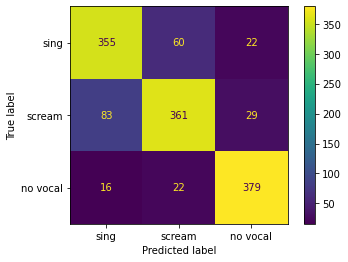

In [30]:
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,ConfusionMatrixDisplay
y_pred=model.predict(X_valid)
# y_pred[np.where(y_pred==np.max(y_pred))] = 1


predicted=np.argmax(y_pred, axis=1)
ground_truth=np.argmax(y_valid, axis=1)

# cm=confusion_matrix(ground_truth,predicted)
# score=precision_score(ground_truth,predicted, average='macro')
# acc = accuracy_score(ground_truth,predicted)

cm,acc,f1,macro_acc,classwise_acc = eval_metrics(ground_truth,predicted)
print(f"Overall Accuracy Score: {acc}")
print("Class-wise accuracy:")
for row in cm:
    print(row/row.sum())
print(f"Macro Accuracy: {macro_acc}")
print(f"F1 score: {f1}")

print("Confusion Matrix:")
# print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sing','scream','no vocal']).plot()

In [ ]:
from tensorflow.keras.utils import to_categorical
import pandas as pd
import os
import pandas as pd
import soundfile as sf
import numpy as np
from sklearn.utils import shuffle
from sys import platform
from sklearn.model_selection import train_test_split, GroupShuffleSplit

if platform == "linux" or platform == "linux2":
    # linux
    path='/home/vkalbag/projects/'
elif platform == "darwin":
    # OS X
    path='/Users/vedant/Desktop/Programming/'


cols=['video_id','start_time','mid_ts','label','audio','vggish']

d=np.load(f'{path}ScreamDetection/resources/working_data/vocal_only_data_with_vggish.npy',allow_pickle=True)
df = pd.DataFrame(d,columns=cols)

lut = pd.read_csv(f'{path}/ScreamDetection/resources/dataset/lookup.csv')

df=df.merge(lut[['video_id','band_name']],on='video_id')
df

feature_df=df[['label','audio','band_name']]
mapping=[]
# for index,row in feature_df.iterrows():
#     if row['label'] == 'clean':
#         mapping.append(0)
#     if row['label'] == 'highfry':
#         mapping.append(1)
#     if row['label'] == 'layered':
#         mapping.append(1)
#     if row['label'] == 'lowfry':
#         mapping.append(1)
#     if row['label'] == 'midfry':
#         mapping.append(1)
#     if row['label'] == 'no_vocals':
#         mapping.append(2)
for index,row in feature_df.iterrows():
    if row['label'] == 'clean':
        mapping.append(0)
    if row['label'] == 'highfry':
        mapping.append(1)
    if row['label'] == 'layered':
        mapping.append(2)
    if row['label'] == 'lowfry':
        mapping.append(3)
    if row['label'] == 'midfry':
        mapping.append(4)
    if row['label'] == 'no_vocals':
        mapping.append(5)
feature_df.insert(3,'label_mapped',mapping)


d=pd.DataFrame()
d['y_under'] = feature_df['label_mapped'].to_numpy()
d['blah'] = 1

print(d.groupby('y_under')['blah'].count())


from imblearn.under_sampling import RandomUnderSampler
# undersample = RandomUnderSampler(sampling_strategy={0:2462,1:3000,2:3000},random_state=0)
undersample = RandomUnderSampler(sampling_strategy={0:1000,1:1000,2:877, 3:555, 4: 1000, 5: 1000},random_state=0)
X = feature_df[['audio','band_name']].to_numpy()
y=feature_df['label_mapped'].to_numpy()
X_under, y_under = undersample.fit_resample(X, y)

band_names = X_under[:,1]
X_under=X_under[:,0]#.reshape(-1,1).flatten()
y_under=y_under

gss = GroupShuffleSplit(n_splits=5, train_size=.7, random_state=42)
train,test = next(gss.split(X_under, y_under, band_names))
# for train_idx,test_idx in gss.split(X_under, y_under, band_names): 
#     print(train_idx,test_idx)

X_train = X_under[train]
X_test1 = X_under[test]

y_train = y_under[train]
y_test1 = y_under[test]

X_test,X_valid,y_test,y_valid = train_test_split(X_test1, y_test1,test_size=0.5,random_state=42)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
y_valid_hot = to_categorical(y_valid)

X_train,y_train=shuffle(X_train,y_train_hot)
X_test,y_test=shuffle(X_test,y_test_hot)
X_valid,y_valid=shuffle(X_valid,y_valid_hot)

# np.save(f'{path}ScreamDetection/FINAL/working_data_final/x_train-rawaudio.npy', X_train)
# np.save(f'{path}ScreamDetection/FINAL/working_data_final/x_test-rawaudio.npy', X_test)
# np.save(f'{path}ScreamDetection/FINAL/working_data_final/x_valid-rawaudio.npy', X_valid)

# np.save(f'{path}ScreamDetection/FINAL/working_data_final/y_train-rawaudio.npy', y_train)
# np.save(f'{path}ScreamDetection/FINAL/working_data_final/y_test-rawaudio.npy', y_test)
# np.save(f'{path}ScreamDetection/FINAL/working_data_final/y_valid-rawaudio.npy', y_valid)

np.save(f'{path}ScreamDetection/FINAL/working_data_final/x_train-rawaudio-6class.npy', X_train)
np.save(f'{path}ScreamDetection/FINAL/working_data_final/x_test-rawaudio-6class.npy', X_test)
np.save(f'{path}ScreamDetection/FINAL/working_data_final/x_valid-rawaudio-6class.npy', X_valid)

np.save(f'{path}ScreamDetection/FINAL/working_data_final/y_train-rawaudio-6class.npy', y_train)
np.save(f'{path}ScreamDetection/FINAL/working_data_final/y_test-rawaudio-6class.npy', y_test)
np.save(f'{path}ScreamDetection/FINAL/working_data_final/y_valid-rawaudio-6class.npy', y_valid)

In [ ]:
x_train=np.load(f'{path}ScreamDetection/FINAL/working_data_final/x_train-rawaudio-6class.npy',allow_pickle = True)
y_train=np.argmax(np.load(f'{path}ScreamDetection/FINAL/working_data_final/y_train-rawaudio-6class.npy',allow_pickle = True),axis=1)

x_test=np.load(f'{path}ScreamDetection/FINAL/working_data_final/x_test-rawaudio-6class.npy',allow_pickle = True)
y_test=np.argmax(np.load(f'{path}ScreamDetection/FINAL/working_data_final/y_test-rawaudio-6class.npy',allow_pickle = True),axis=1)

x_valid=np.load(f'{path}ScreamDetection/FINAL/working_data_final/x_valid-rawaudio-6class.npy',allow_pickle = True)
y_valid=np.argmax(np.load(f'{path}ScreamDetection/FINAL/working_data_final/y_valid-rawaudio-6class.npy',allow_pickle = True),axis=1)


y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
y_valid_hot = to_categorical(y_valid)





X_train = []
X_test = []
X_valid=[]
for y1 in x_train:
    X_train.append(librosa.power_to_db(librosa.feature.melspectrogram(y=y1, sr=44100)))
for y2 in x_test:
    X_test.append(librosa.power_to_db(librosa.feature.melspectrogram(y=y2, sr=44100)))
for y3 in x_valid:
    X_valid.append(librosa.power_to_db(librosa.feature.melspectrogram(y=y3, sr=44100)))






X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)

X_train = X_train.reshape(X_train.shape[0], 128, 87, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 87, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 128, 87, 1)

X_train,y_train=shuffle(X_train,y_train_hot)
X_test,y_test=shuffle(X_test,y_test_hot)
X_valid,y_valid=shuffle(X_valid,y_valid_hot)





import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3





# model
model = Sequential()
kernel=(3,3)
input_shape = (128, 87, 1)
model.add(Conv2D(256, kernel_size=kernel, activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=kernel))
model.add(Conv2D(512, kernel_size=kernel, activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=kernel))
model.add(Conv2D(1024, kernel_size=kernel, activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=kernel))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))

epochs=20
batch_size=32
lr = 0.000001
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])

model.summary()



# fit the model
history=model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, y_valid))
model_name=f"cnn64dense_kernel_{str(kernel).replace(',','x').replace(' ','')[1:-1]}_batch-{batch_size}_epochs_{epochs}_lr_{str(lr).replace('.','_')}_adadelta"
# model.save(f'{path}ScreamDetection/CNN/trained_models/{model_name}')

training_loss=history.history['loss']
validation_loss=history.history['val_loss']
training_acc=history.history['accuracy']
validation_acc=history.history['val_accuracy']
import plotly.express as px
from plotly.subplots import make_subplots
# fig=px.line(training_loss)
# fig.add_scatter(validation_loss, mode='lines')

import pandas as pd
df=pd.DataFrame()
df['training_loss'] = training_loss
df['validation_loss'] = validation_loss
df['training_acc'] = training_acc
df['validation_acc'] = validation_acc
# model.save(f'{path}ScreamDetection/CNN/trained_models/{model_name}')
# df.to_csv(f'{path}ScreamDetection/CNN/trained_models/{model_name}.csv')

trace1 = go.Scatter(
x=df.index,
    y=df['training_loss'],
    name='Training Loss'
)
trace2 = go.Scatter(
    x=df.index,
    y=df['validation_loss'],
    name='Validation Loss'
)
trace3 = go.Scatter(
    x=df.index,
    y=df['training_acc'],
    name='Training Accuracy',
    yaxis='y2'
)
trace4 = go.Scatter(
    x=df.index,
    y=df['validation_acc'],
    name='Validation Accuracy',
    yaxis='y2'
)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3,secondary_y=True)
fig.add_trace(trace4,secondary_y=True)
fig.update_yaxes(range=[0,1],secondary_y=True)
fig.update_layout(title_text='Training Results', title_x=0.45)
# Set x-axis title
fig.update_xaxes(title_text="Epochs")

# Set y-axes titles
fig.update_yaxes(title_text="Loss", secondary_y=False)
fig.update_yaxes(title_text="Accuracy", secondary_y=True)
fig.show()





from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,ConfusionMatrixDisplay
y_pred=model.predict(X_test)
# y_pred[np.where(y_pred==np.max(y_pred))] = 1


predicted=np.argmax(y_pred, axis=1)
ground_truth=np.argmax(y_test, axis=1)

cm=confusion_matrix(ground_truth,predicted)
score=precision_score(ground_truth,predicted, average='macro')
acc = accuracy_score(ground_truth,predicted)


print(f"Overall Accuracy Score: {acc}")
print("Class-wise accuracy:")
for row in cm:
    print(row/row.sum())
print(f"Macro Accuracy: {score}")

print("Confusion Matrix:")
# print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sing','high fry','layered','lowfry','midfry','no vocal']).plot()




model.save(f'{path}ScreamDetection/CNN/trained_models/6class/{model_name}')
df.to_csv(f'{path}ScreamDetection/CNN/trained_models/6class/{model_name}.csv')